## MNIST data with a convolutional neural network (CNN)

MNIST dataset was downloaded from kaggle.com in .csv format.

train.csv: contains 42000 train example. Each row in the csv file contains the digit label in the first column, and 784 pixels values of the image in the following columns.

Before building a CNN to classify the MNIST data, I tried using both a random forest and a fully-connected neural networks. The accuracies were 96.4% for the random forest, and 96.6% for the neural network. 

However, neither the random forest not the neural network take advantages of the image-specific properties of our data, i.e., low-level edges and shapes in the pictures. Thus, a CNN should be advantegous over both previous methods. 


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
%matplotlib inline  

Load data and convert to numpy arrays 'labels' and 'train':

In [2]:
dataset = pd.read_csv(r"~/Python/Kaggle Digits/train.csv")
labels = dataset['label'].values
train = dataset.iloc[:, 1:].values

In [3]:
print 'Train set: ' + str(train.shape)
print 'Labels: ' + str(labels.shape)

Train set: (42000, 784)
Labels: (42000,)


Normalize Data to zero mean and unit variance:

In [4]:
def normalizeData(X): 
    #input: X: 2D-numpy array with shape (#datapoints, #features)
    #output: normalized X
    return (X -128.0)/255.0
X = normalizeData(train)

For a neural network, we need to reformat our labels (0,1,2,3, ...9) into one-hot encoded labels, i.e.:
label 1 is represented as [1.0, 0.0, 0.0 ...], 
label 2 is represented as [0.0, 1.0, 0.0 ...], etc.

In [5]:
def reformatLabels(labels):
    #input: 1D numpy array labels with shape (#samples)
    #output: 2D numpy array of encoded labels with shape (#samples, #labels)
    num_labels = len(np.unique(labels))
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels
print 'Labels before reformating: ' + str(labels.shape)
labels = reformatLabels(labels)
print 'Labels after reformating:  ' + str(labels.shape)

Labels before reformating: (42000,)
Labels after reformating:  (42000, 10)


Currently, the train data X is in the shape of (#samples, #pixels). However, for a CNN with Tensorflow, we  need the input data to be in the shape of (#samples, imagesize, imagesize, #channels).

In [6]:
def reformatData(X, num_channels = 1):
    #input: X: 2D-numpy array with shape (#datapoints, #features)
    #input: num_channels: integer, number of RGB channels.
    image_size  = int(math.sqrt(X.shape[1]))
    X = X.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    #Note: since Tensorflow cannot deal with numpy float 64 array, we convert it to float32
    return X
print 'Data before reformating: ' + str(X.shape)
X = reformatData(X)
print 'Data after reformating:  ' + str(X.shape)

Data before reformating: (42000, 784)
Data after reformating:  (42000, 28, 28, 1)


Let's check that reformating to images went well:

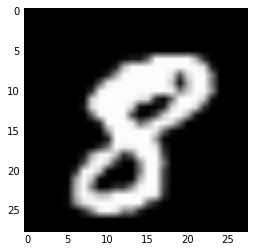

In [7]:
plt.figure()
plt.imshow(X[10, :,:,0], cmap=plt.cm.gray)

Divide the data into random test and train set:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=0)
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(37800, 28, 28, 1)
(37800, 10)
(4200, 28, 28, 1)
(4200, 10)


Define variables for CNN:

In [9]:
image_size  = 28     #image size of MNIST data: 28x28 pixels
num_labels = 10      #number of classes in the data set
num_channels = 1     #number of RGB channels
batch_size = 128     #batch used in each training pass
learningrate = 0.001 #learning rate 
alpha =  0.002       #regularization strength
train_epochs = 100   #for how many epochs we want to train the network
totalsteps = int((train_epochs * X_train.shape[0])/batch_size) #calculate #train passes

In [10]:
graph = tf.Graph()
with graph.as_default():
    
    #function for initializtion of weights and biases
    def weight_variable(shape):
        return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
    def bias_variable(shape):
        return tf.Variable(tf.constant(0.1, shape = shape))

    #maxpool defintion    
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # define Input data dimensions
    tf_X_train = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_y_train = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_X_test = tf.constant(X_test)
    
    #network definition
    #layer 1
    #3x3 convolution filter, 16 feature maps
    patch_size1 = 3
    depth1 = 16
    layer1_weights = weight_variable([patch_size1, patch_size1, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    
    #layer 2
    #3x3 convolution filter, 16 feature maps 
    patch_size2 = 3
    depth2 = 16
    layer2_weights = weight_variable([patch_size2, patch_size2, depth1, depth2])
    layer2_biases =  bias_variable([depth2])
    
    #layer 3
    #5x5 convolution filter, 32 feature maps
    patch_size3 = 5
    depth3 = 32    
    layer3_weights = weight_variable([patch_size3, patch_size3, depth2, depth3])
    layer3_biases = bias_variable([depth3])

    #layer 4
    #fully connected layer 1
    num_hidden = 1024
    layer4_weights = weight_variable([image_size//4 * image_size//4  * depth3, num_hidden])
    layer4_biases =  bias_variable([num_hidden])
    
    #layer 5
    #fully connected layer
    num_hidden2 = 1024
    layer4a_weights = weight_variable([num_hidden, num_hidden2])
    layer4a_biases =  bias_variable([num_hidden2])

    #output layer
    layer5_weights = weight_variable([num_hidden2, num_labels])
    layer5_biases = bias_variable([num_labels])
    
    #make a list of the weights
    weights = [layer1_weights,  layer2_weights, layer3_weights,  layer4_weights, layer4a_weights, layer5_weights ]
  

  # Model definition (= forward propagation)
    def model(data, dropout = False):
        if dropout == True:
            keepprob = 0.5
        else:
            keepprob = 1.0
            
        #layer C1
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') 
        hidden = tf.nn.relu(conv + layer1_biases)

        #layer C2
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = max_pool_2x2(hidden)

        #layer C3
        conv = tf.nn.conv2d(hidden, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = max_pool_2x2(hidden)
        
        #reshape for FC layer
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        #layer F4
        hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        hidden = tf.nn.dropout(hidden, keepprob)

        #layer F4a
        hidden = tf.nn.relu(tf.matmul(hidden, layer4a_weights) + layer4a_biases)
        hidden = tf.nn.dropout(hidden, keepprob)

        #output layer
        return tf.matmul(hidden, layer5_weights) + layer5_biases  
  
    # Define Training computation.
    # note: dropout = True
    logits = model(tf_X_train, dropout = True)
    
    # loss function for regularization
    l2 = tf.nn.l2_loss(weights[0])  #initialize
    for i in range(1, len(weights)):
        l2 += tf.nn.l2_loss(weights[i])

    #loss function of forward pass
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_y_train)) + alpha*l2
       
    # Optimizer.
    global_step = tf.Variable(0, name='global_step', trainable=False) # count the number of steps taken
    #learning_rate = tf.train.exponential_decay(learningrate, global_step, 3000, 0.9, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #
    #note: for Adam, the learning rate is decreasing with time. Thus, we don't explicitly need to set up
    #learning rate decay
    optimizer = tf.train.AdamOptimizer(learningrate).minimize(loss, global_step=global_step)  
 
 
    #Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(model(tf_X_train))
    test_prediction = tf.nn.softmax(model(tf_X_test))
         

Also, we need to define a function that yields the input/indices for each batch of training data:

In [11]:
def yield_next_batch_generator(sizeX, batch_size):
    #Generator function which returns indices of samples (batches) used for each training pass
    
    currentindex = 0
    indeces = np.arange(0,sizeX) 
    np.random.shuffle(indeces)
    while True:  
        start = currentindex
        currentindex += batch_size
        # when all trainig data have been already used, it is shuffled and currentindex is reset
        if currentindex > sizeX:
            np.random.shuffle(indeces)
            start = 0
            currentindex = batch_size
        end = currentindex
        yield indeces[start:end] 

We need to define an metric for the classifier. For this problem, we can use classification accuracy:

In [12]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Now we can initialize and train the network:

In [13]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    print 'Training for a total number of steps of: ' + str(totalsteps) 
    
    #Initialize generator:
    g = yield_next_batch_generator(X_train.shape[0], batch_size)
    #start training loop
    for step in xrange(totalsteps):
        indeces = g.next() #indeces from generator
        feed_dict = {tf_X_train : X_train[indeces, :], tf_y_train : y_train[indeces, :]}

        # Run forward and backward pass and update weights
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        #print global_step
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, y_train[indeces, :]))
        if (step % 2000 == 0):
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))
            print ' ' 
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))
    print 'Done training!'

Initialized
Training for a total number of steps of: 29531
Minibatch loss at step 0: 36.703938
Minibatch accuracy: 10.9%
Test accuracy: 9.1%
 
Minibatch loss at step 500: 4.313422
Minibatch accuracy: 98.4%
Minibatch loss at step 1000: 1.218288
Minibatch accuracy: 99.2%
Minibatch loss at step 1500: 0.641536
Minibatch accuracy: 95.3%
Minibatch loss at step 2000: 0.293112
Minibatch accuracy: 100.0%
Test accuracy: 98.4%
 
Minibatch loss at step 2500: 0.234806
Minibatch accuracy: 100.0%
Minibatch loss at step 3000: 0.211172
Minibatch accuracy: 99.2%
Minibatch loss at step 3500: 0.227437
Minibatch accuracy: 99.2%
Minibatch loss at step 4000: 0.202367
Minibatch accuracy: 97.7%
Test accuracy: 98.3%
 
Minibatch loss at step 4500: 0.240967
Minibatch accuracy: 96.9%
Minibatch loss at step 5000: 0.257879
Minibatch accuracy: 96.9%
Minibatch loss at step 5500: 0.155636
Minibatch accuracy: 99.2%
Minibatch loss at step 6000: 0.142717
Minibatch accuracy: 100.0%
Test accuracy: 98.7%
 
Minibatch loss at 

For the CNN, we get an accuracy of 98.6% - 99.0% on the testset. That is definitely an improvement over the random forest and fully connected neural network!